# Phase 1

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import os
import tensorflow as tf
import cv2
import random
import xml.etree.ElementTree as ET
from IPython.display import display



In [3]:
image_dir = '../data/dataset_xml_format/dataset_xml_format/'



In [4]:
for filename in os.listdir(image_dir):
    if filename.endswith(".png"):
        # Load the image using OpenCV
        image_path = os.path.join(image_dir, filename)
        img = cv2.imread(image_path)
        

The two functions below are being used to load all images and corresponding labels from the dataset into the notebook. 

In [31]:
# Define a function to load and convert images into numpy arrays
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img = Image.open(os.path.join(folder, filename))
            img_arr = np.asarray(img)
            images.append(img_arr)
    return np.array(images)

# Define a function to load and pair the labels with the images
def load_labels(folder):
    labels = {}
    for filename in os.listdir(folder):
        if filename.endswith('.xml'):
            with open(os.path.join(folder, filename), 'r') as f:
                label = f.read()
                labels[filename[:-4]] = label
    return labels

# Load the images and labels
images = load_images('../data/dataset_xml_format/dataset_xml_format/')
labels = load_labels('../data/dataset_xml_format/dataset_xml_format/')

# Print the shape of the images array and some example labels
print(images.shape)
print(labels.keys())


(300, 720, 1280, 3)
dict_keys(['foto00088', 'foto00117', 'foto00204', 'foto00233', 'foto00262', 'foto00291', 'foto00320', 'foto00349', 'foto00378', 'foto00987', 'foto01016', 'foto01045', 'foto01074', 'foto01103', 'foto01161', 'foto01190', 'foto01219', 'foto01248', 'foto01277', 'foto01306', 'foto01335', 'foto01364', 'foto01393', 'foto01422', 'foto01451', 'foto01480', 'foto01509', 'foto01538', 'foto01567', 'foto01596', 'foto01625', 'foto01654', 'foto01683', 'foto01712', 'foto01741', 'foto01770', 'foto01799', 'foto01828', 'foto01857', 'foto01886', 'foto01915', 'foto01944', 'foto01973', 'foto02002', 'foto02031', 'foto02060', 'foto02756', 'foto02785', 'foto02814', 'foto02843', 'foto02872', 'foto04235', 'foto04264', 'foto04293', 'foto04322', 'foto04351', 'foto04380', 'foto04409', 'foto04438', 'foto04467', 'foto04496', 'foto04670', 'foto04699', 'foto04728', 'foto04757', 'foto04786', 'foto04815', 'foto04844', 'foto04873', 'foto04902', 'foto04931', 'foto04960', 'foto04989', 'foto05018', 'foto05

In [5]:
#Creating a list to hold three different images a drone for sampling
drone_p = ['../data/dataset_xml_format/dataset_xml_format/foto05656.png', 
           '../data/dataset_xml_format/dataset_xml_format/foto14878.png', 
           '../data/dataset_xml_format/dataset_xml_format/moto15922.png' 
           ]


For the first part of this notebook, we will apply a few processing methods to the sample list of images in order to create visuals. Only a small sample (3) of the images will be displayed and the larger collection of images will undergo the same procedures in order to better understand the pixel values and to prepare the images for modeling. 

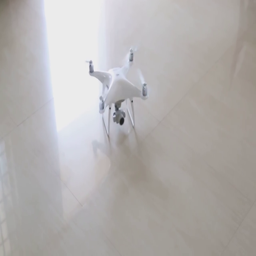

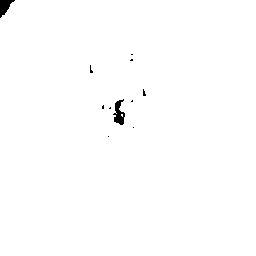

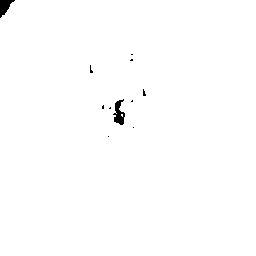

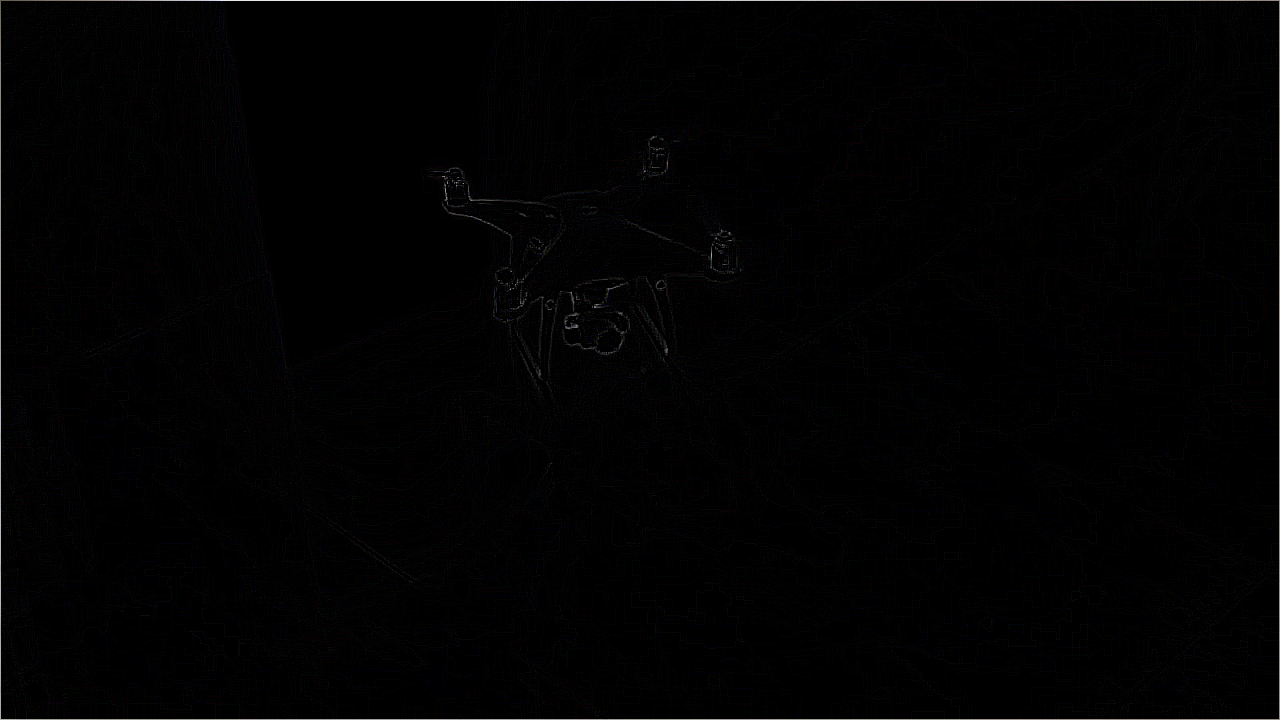

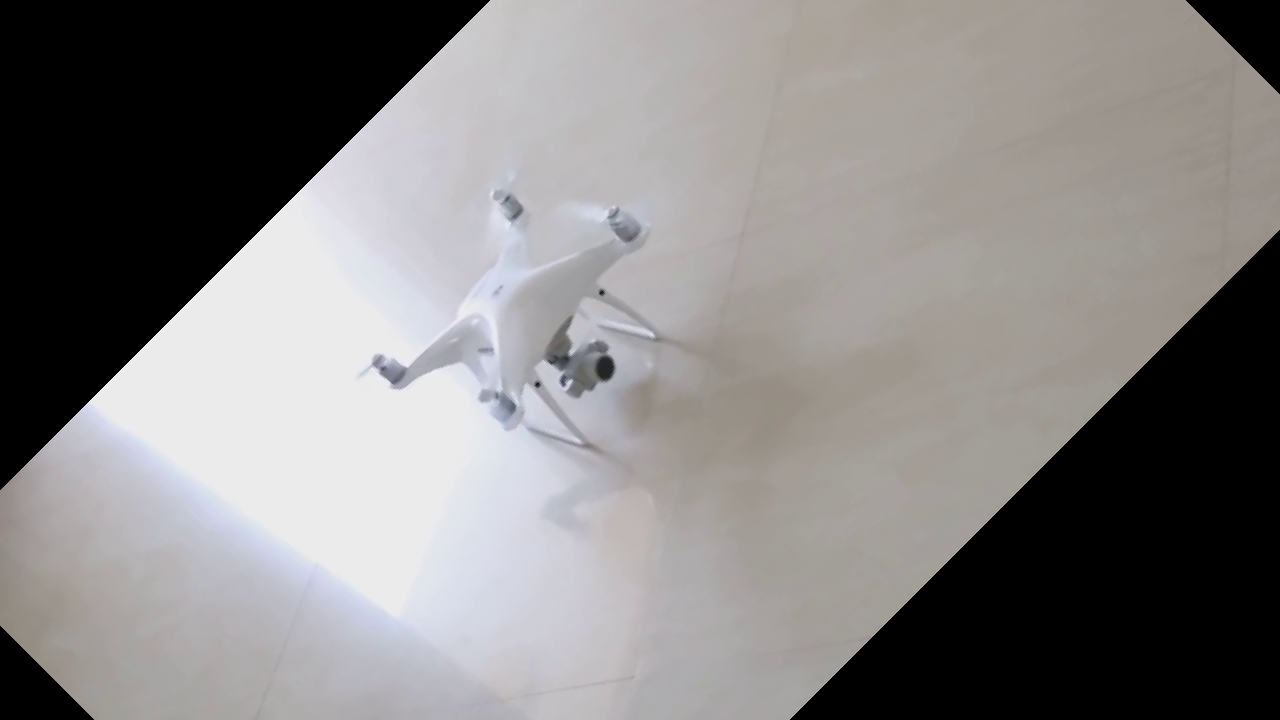

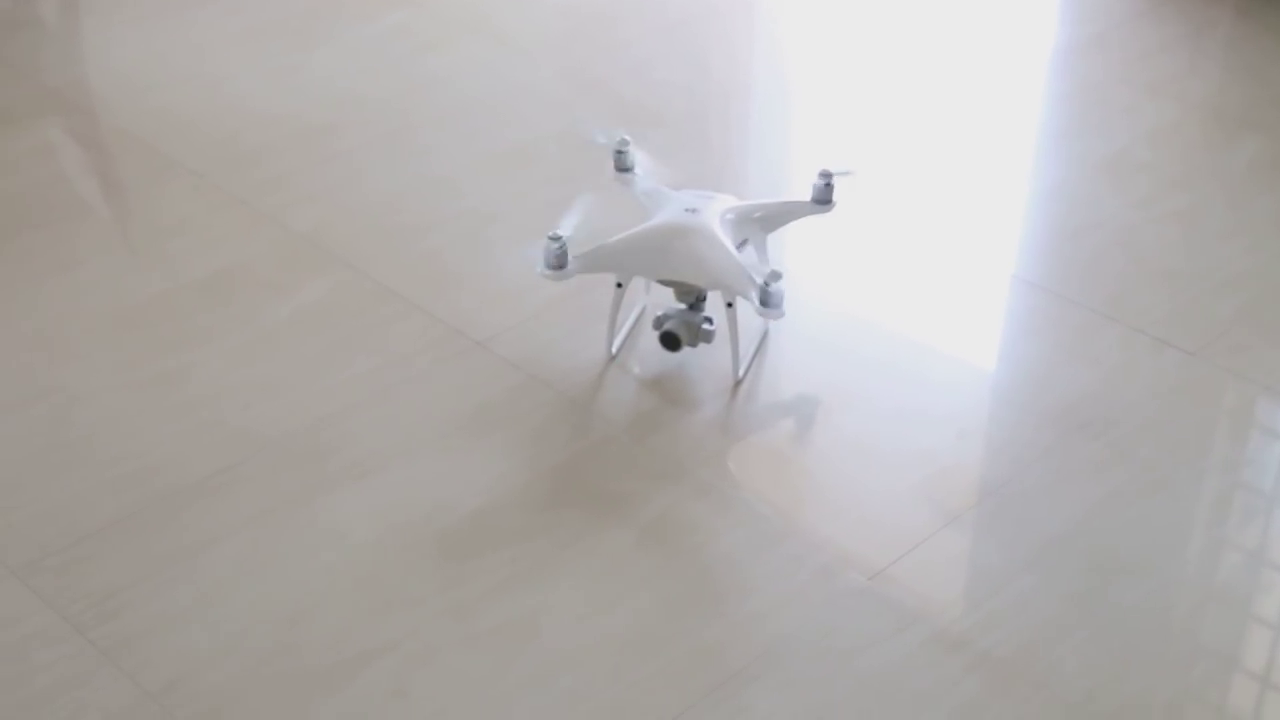

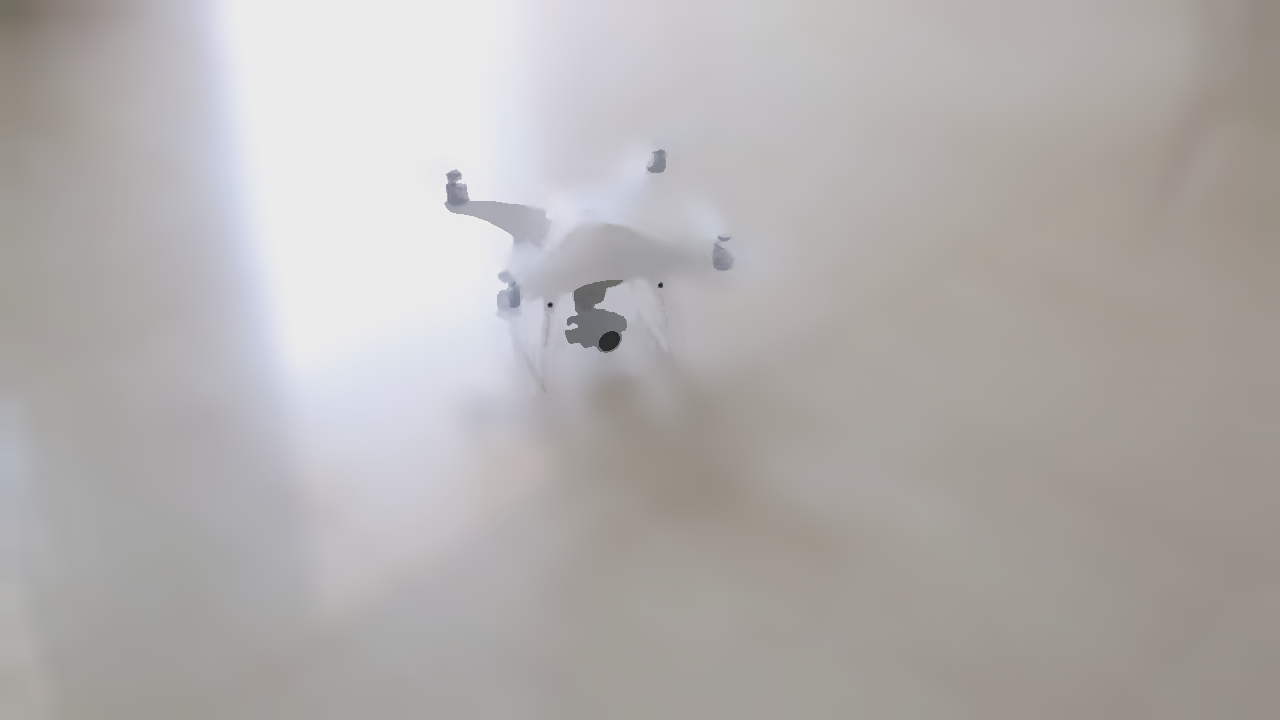

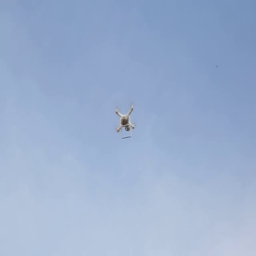

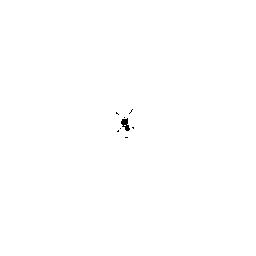

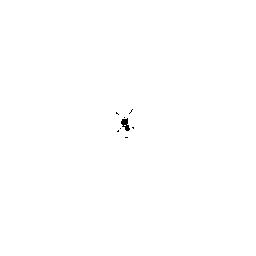

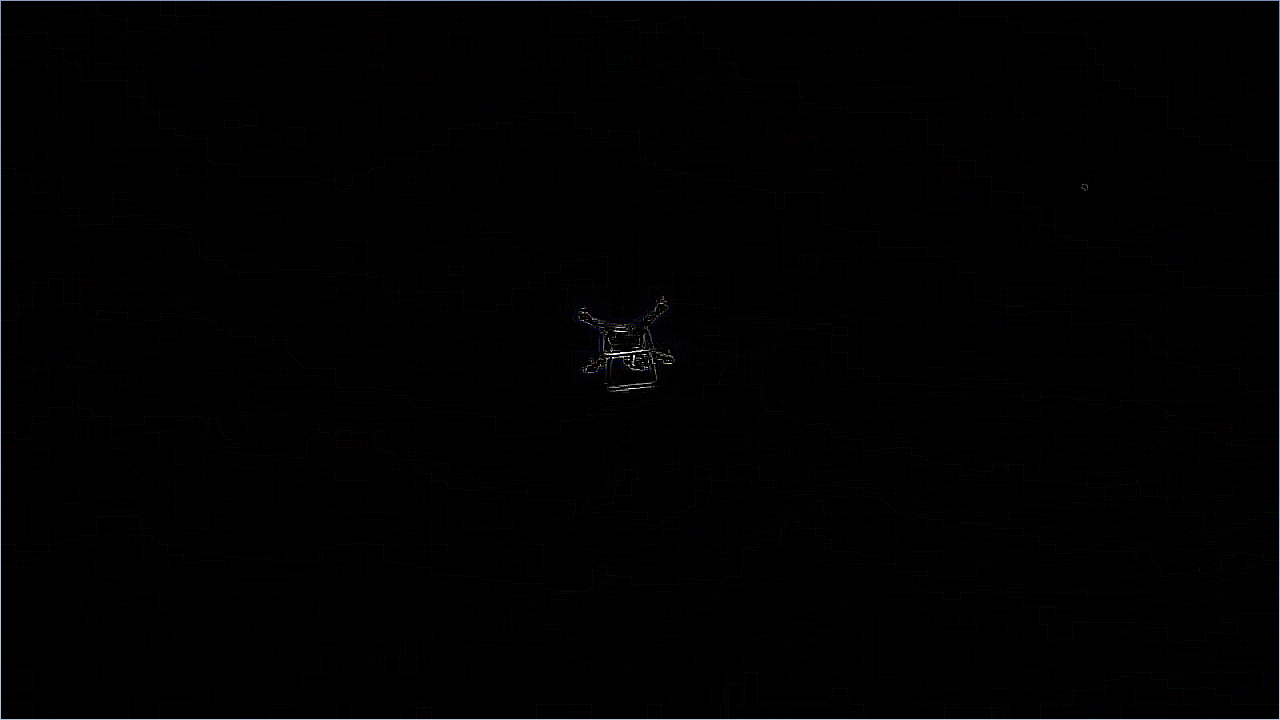

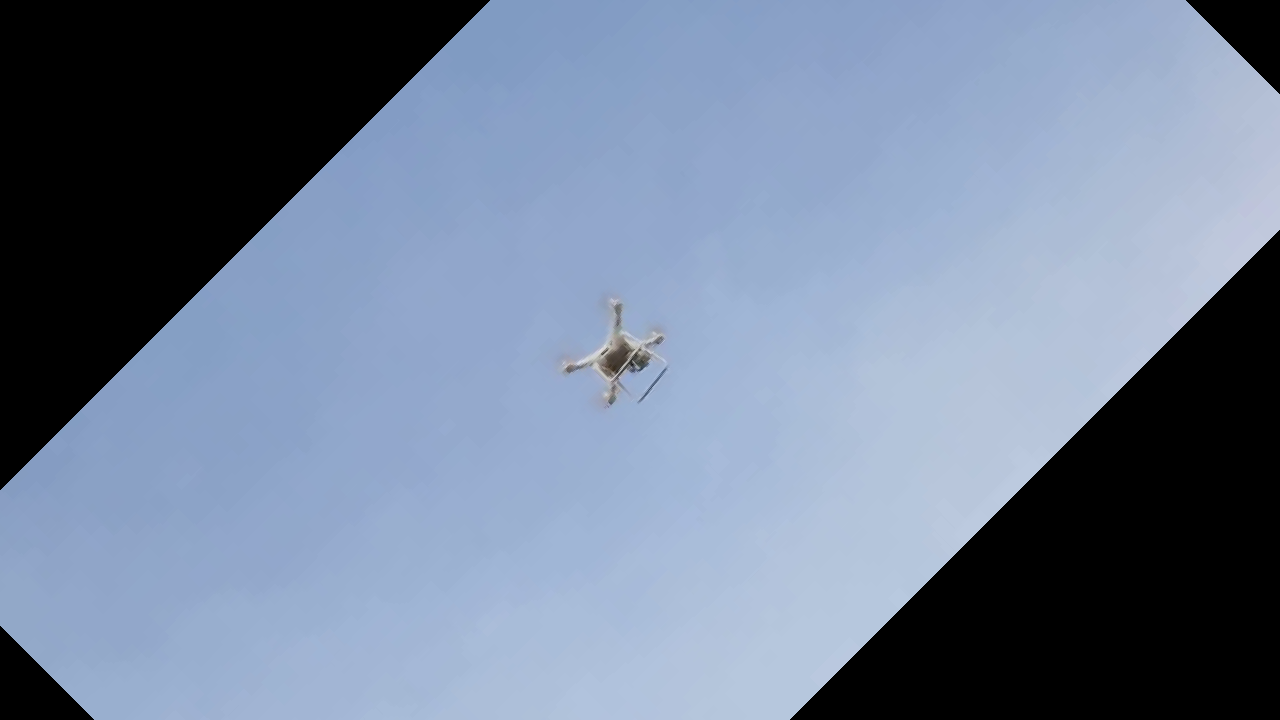

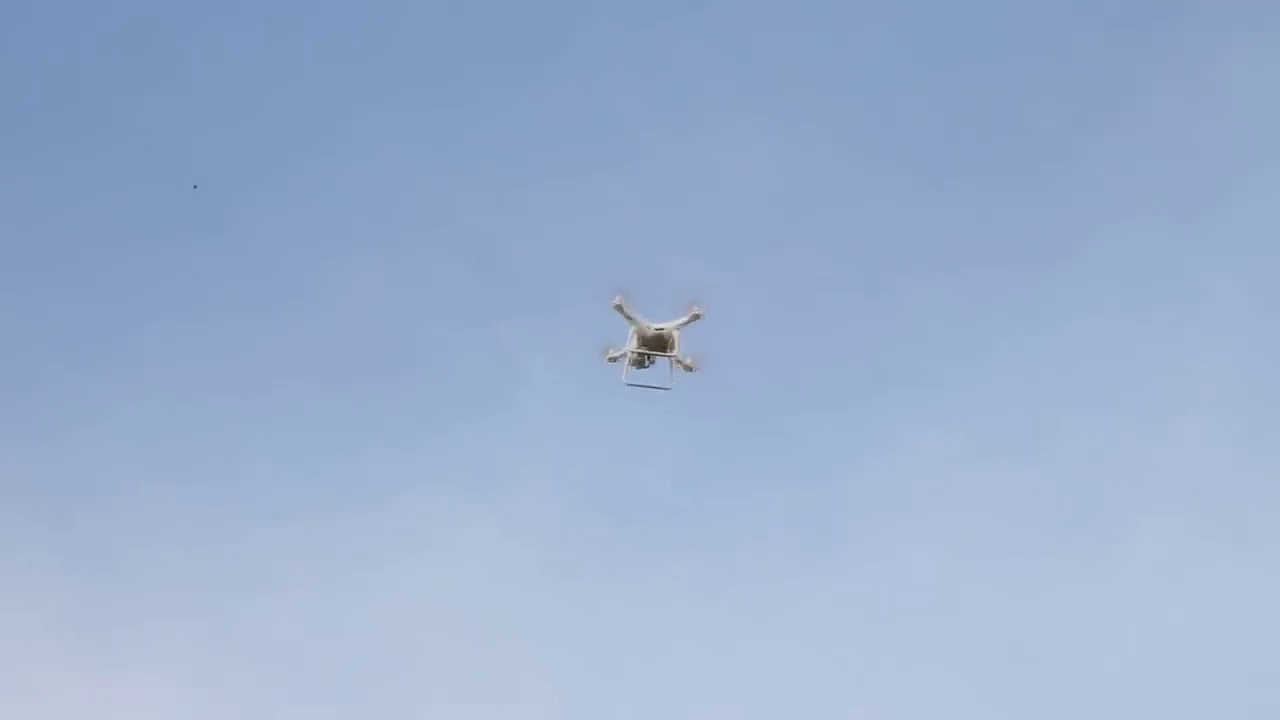

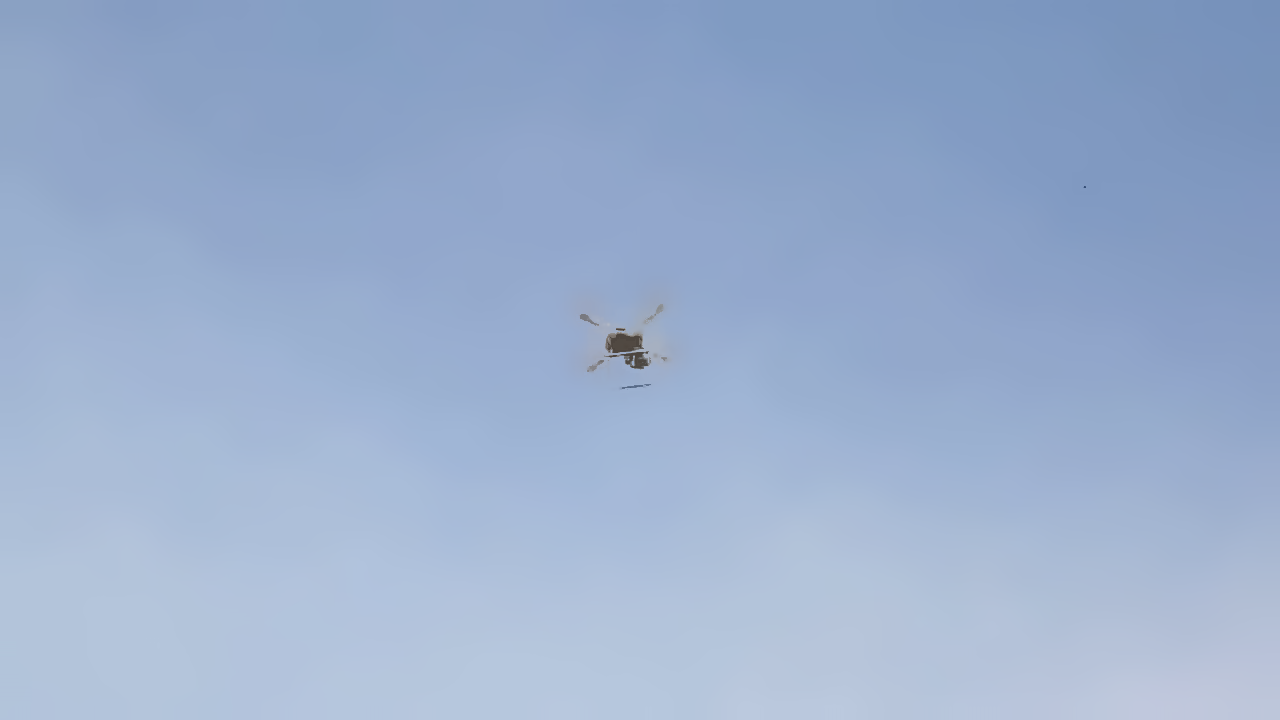

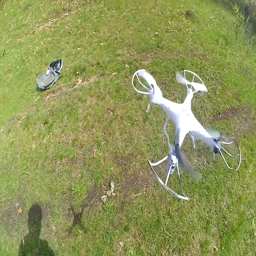

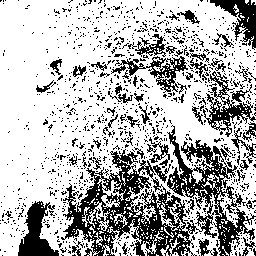

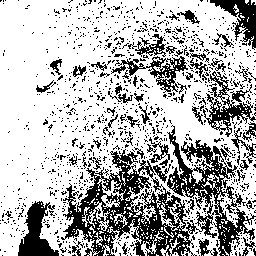

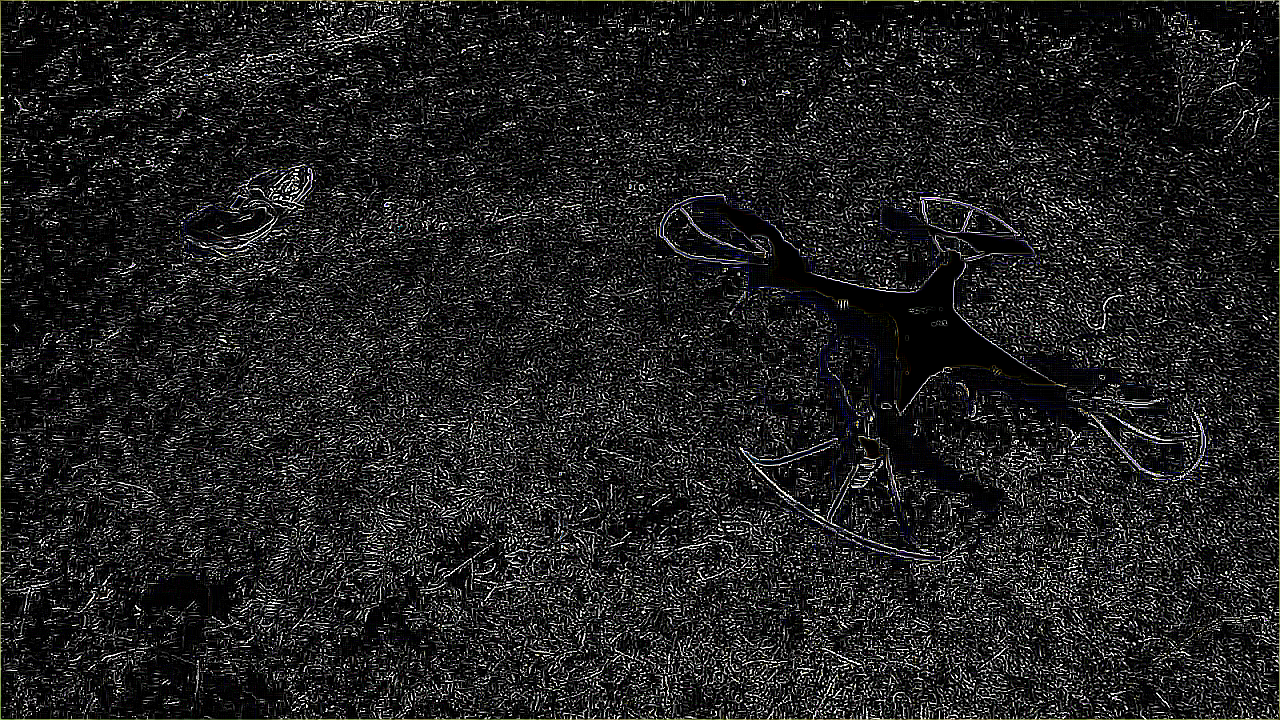

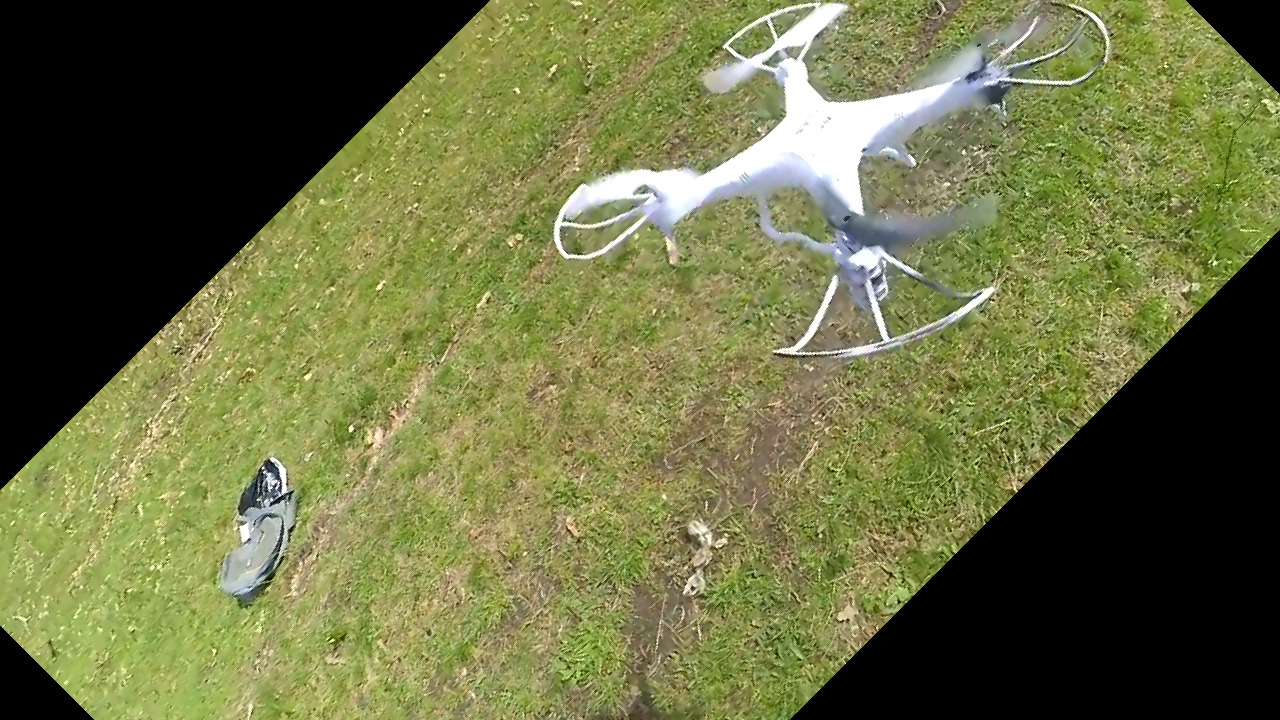

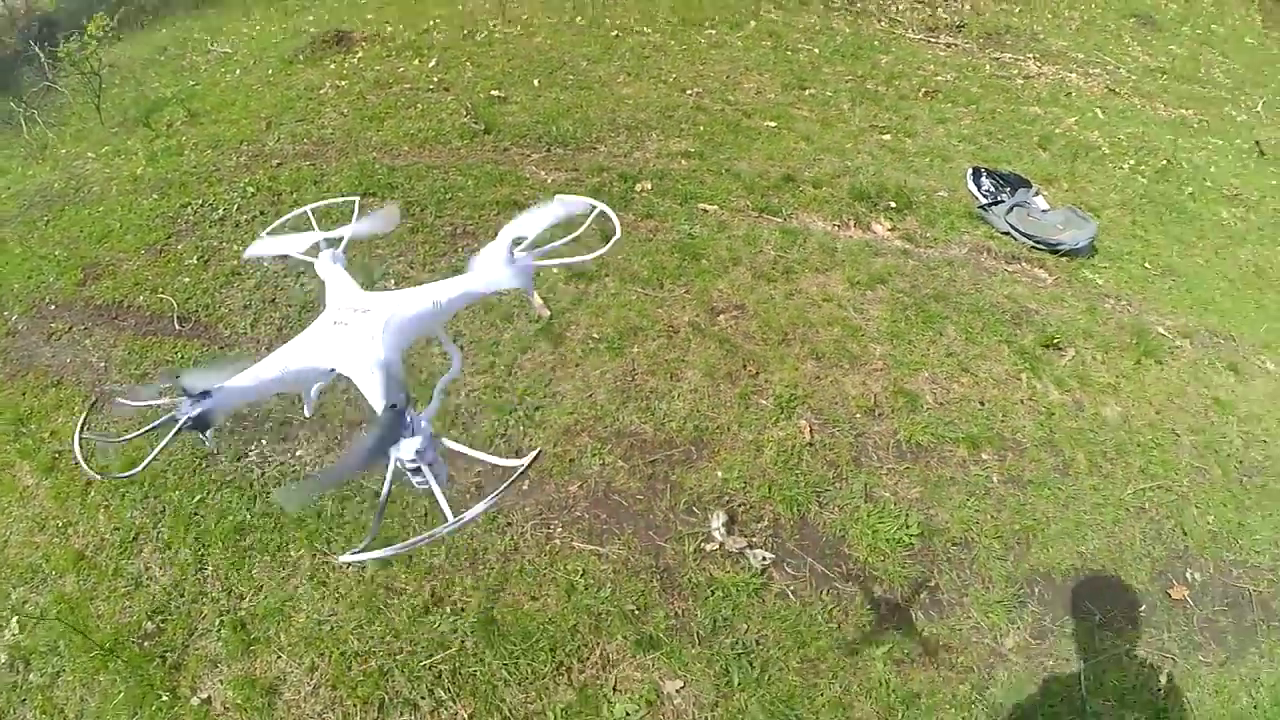

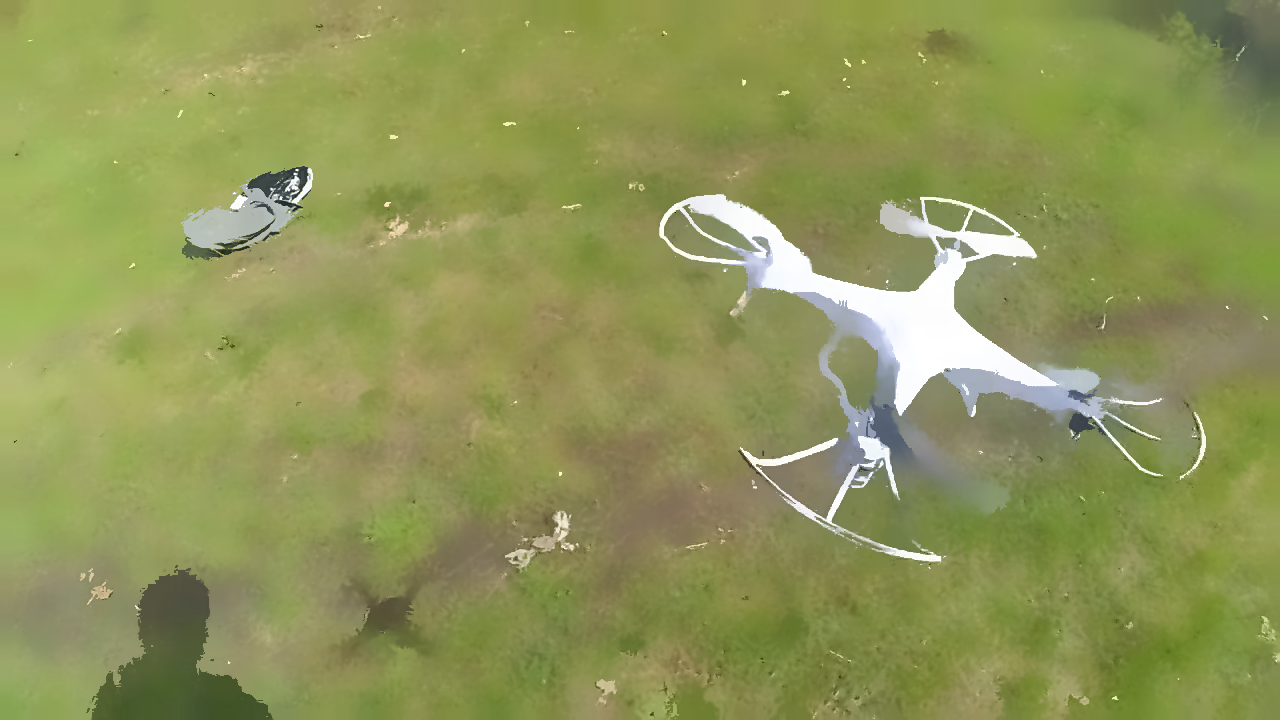

In [6]:
for image_file_path in drone_p:
    img = Image.open(image_file_path)
    
    #Scaling the image
    scaled_img = img.resize((256, 256))
    
    #Applying thresholding
    threshold = 128
    thresholded_img = np.array(scaled_img.convert("L")).copy()
    thresholded_img[thresholded_img > threshold] = 255
    thresholded_img[thresholded_img <= threshold] = 0
    thresholded_img = Image.fromarray(thresholded_img)
    
    #Applying filters to the images
    sharpen_kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    sharpened_img = cv2.filter2D(np.array(thresholded_img), -1, sharpen_kernel)
    
    #Applying edge detection filters
    edged = img.filter(ImageFilter.FIND_EDGES)
    
    #Transforming the images
    rotated_img = img.rotate(angle = 45)
    flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT) 
    
    #Performing segmentation
    img_np = np.array(img)
    segmented_img_np = cv2.pyrMeanShiftFiltering(img_np, sp=15, sr=50)
    segmented_img = Image.fromarray(segmented_img_np)
    
    #Displaying the images
    display(scaled_img)
    display(thresholded_img)
    display(Image.fromarray(sharpened_img))
    display(edged)
    display(rotated_img)
    display(flipped_img)
    display(segmented_img)

The images above have been sharpened, and edge detection filters have been applied. This will help later on with our image segmentation and collision detection tests

# Exploratory Data Analysis (EDA)
The next phase in this notebook is to further explore all of the images present in the dataset. This phase of the notebook will include plotting a histogram with pixel values, examining the RGB color channels

In [7]:
data_path = '../data/dataset_xml_format/dataset_xml_format/'
im_list = []

for filename in os.listdir(data_path):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        image = Image.open(os.path.join(data_path,filename))
        im_list.append(image)

In [8]:
image_list = []
for image_file_path in im_list:
    image_array = np.array(image)
    image_list.append(image_array)
    


mean_pixel_value = np.mean(image_array)
stddev_pixel_value = np.std(image_array)


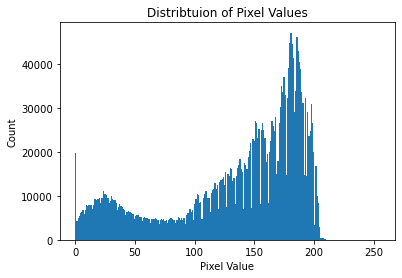

In [9]:
flatten_image_array = image_array.flatten()

#Plotting a histogram of pixel values
plt.hist(flatten_image_array, bins=256)
plt.title('Distribtuion of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Count')
plt.show()

The x-axis of the histogram represents the range of pixel values from 0 to 255, and the y-axis represents the frequency of occurence for each value. The plot shows that the majority of pixel values in the images falls between 150-200 with a peak around 175. This suggests that the images have a relatively high overall brightness, with most of the pixels being in the mid-range of possible pixel values. 

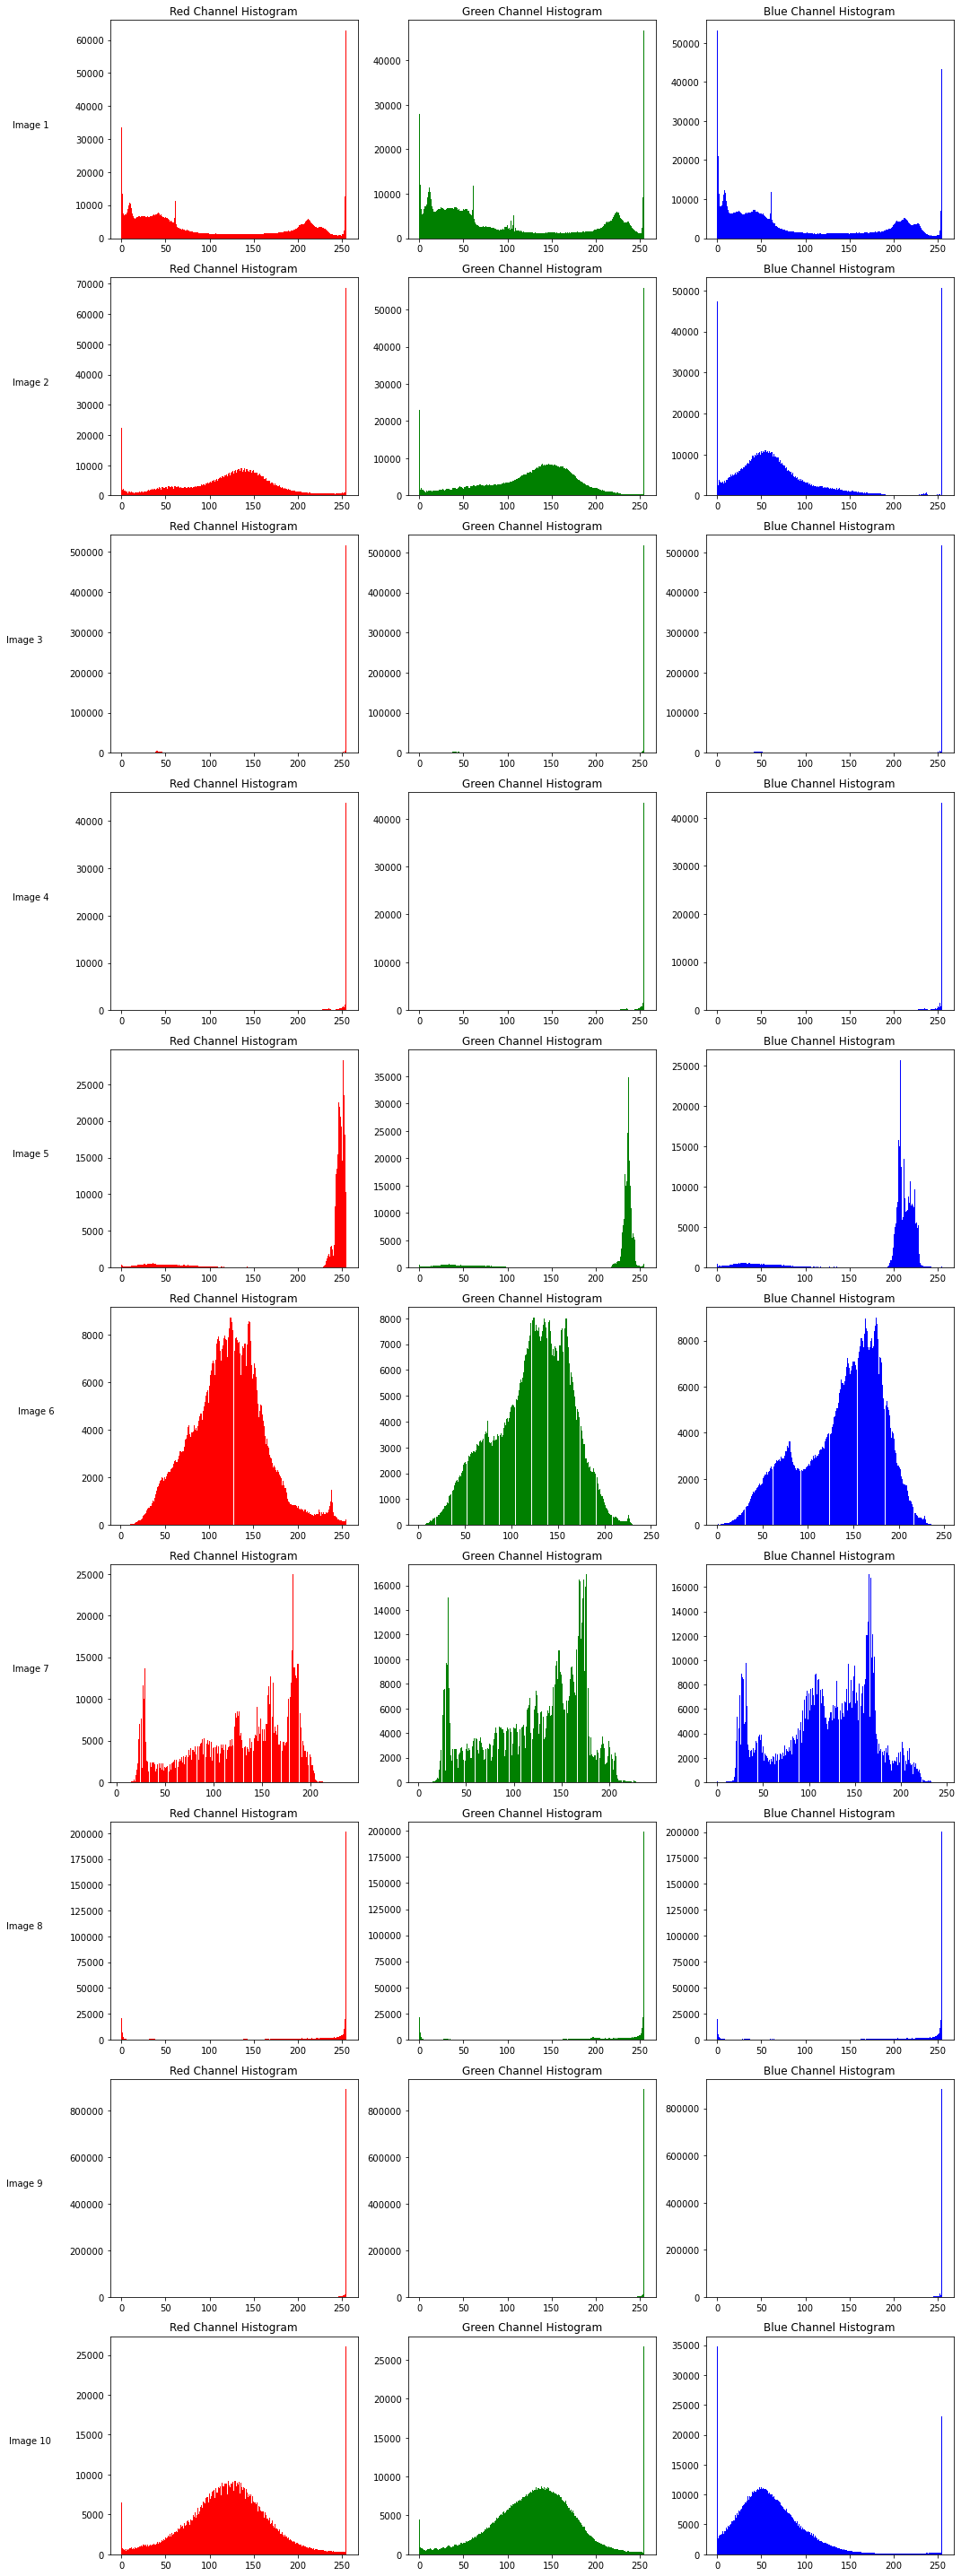

In [10]:
def plot_rgb_hist(image_path, ax):
    image_array = np.array(image_path)

    red_channel = image_array[:, :, 0].ravel()
    green_channel = image_array[:, :, 1].ravel()
    blue_channel = image_array[:, :, 2].ravel()

    ax[0].hist(red_channel, bins=256, color='red')
    ax[0].set_title('Red Channel Histogram')
    ax[1].hist(green_channel, bins=256, color='green')
    ax[1].set_title('Green Channel Histogram')
    ax[2].hist(blue_channel, bins=256, color='blue')
    ax[2].set_title('Blue Channel Histogram')

random_im_list = random.sample(im_list, 10)
fig, axes = plt.subplots(10, 3, figsize=(15, 40))
for i, image_path in enumerate(random_im_list):
    plot_rgb_hist(image_path, axes[i])
    axes[i, 0].set_ylabel(f'Image {i+1}', rotation=0, labelpad=50)
    
fig.tight_layout()
plt.show()


The code above performs an analysis of the RGB color channels in each of the images that were used earlier. By examining these histograms, we can see the overall color distribution for each image and identify any dominant colors or color palettes that are present. Based on the results from the histograms, it looks like there is no clear dominant color in the sample of images from the dataset.

In this phase of the project, we performed data wrangling and exploratory data analysis (EDA) on a range of drone images. We used various techniques to gain insights into the data, such as examining color channels, and identifying objects.

Overall, this phase provides a good starting point for further analysis and modeling of the drone image dataset. We can use the insights gained from this analysis to inform decisions about preprocessing steps, feature selection, and model selection. 